# GroupFasterRisk Tutorial 
GroupFasterRisk is FasterRisk with added functionalities designed to empower the algorithm to be more broadly applicable. We describe the usage of each added functionalities below. 

Note: We conducted a study on applying GroupFasterRisk to predicting in-hospital mortality rate in critical care. The paper is accepted by *Journal of the American Medical Informatics Association* and can be accessed at arXiv: https://arxiv.org/abs/2311.13015. This tutorial demonstrates how to use the new functionalities in practice.

## Group Sparsity
We first demonstrate the group sparsity constraint functionality added to FasterRisk. Group sparsity allows the users to define an arbitrary partition on the feature indices, and the user can control the risk score output using group sparsity constraint hyperparameter. In plain words, group sparsity constraints allow users to define their own grouping of the features and control the number of such groups. 

Group sparsity can be particularly useful on some specific settings such as healthcare, where summary statistics of a longitudinal measurement are used for prediction. To demonstrate how this is useful, we would like to provide an example below.

*Note: due to privacy concerns, we use a synthetic healthcare dataset created by ourselves for the sake of this tutorial*

### Create synthetic data

We create a synthetic dataset consisted of 5000 patients, each having 10 variables, and the label is in-hospital mortality

| Variable Name | Abbreviation | Data Type |
| :------------ | ------------- | --------- |
| Mean blood pressure | `mbp` | Numerical |
| Age | `age` | Numerical |
| Urine output | `urine_output` | Numerical |
| Blood pH | `pH` | Numerical |
| Partial pressure of carbon dioxide | `pco2` | Numerical |
| Partial pressure of oxygen | `po2` | Numerical |
| Heart rate | `heartrate` | Numerical |
| Respiratory rate | `resprate` | Numerical |
| Glascow Coma Score | `gcs` | Discrete |
| Whether on mechanical ventilation | `mechvent` | Categorical |

For each numerical feature, we have a minimum and a maximum statistic. We used maximum and minimum because extreme measurement deviations can be meaningful. (Generally, any number of summary statistics can work, but for sake of an example, we choose two for now.)

Lastly, although each patients have 10 variables (measurements), the number of features is 17 due to the minimums and maximums on numerical features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

assumed_stats = {
    "mbp_min": {    # numerical
        "mean": 120,
        "std": 40,
        "diff": -40, 
    },
    "mbp_max": {    # numerical
        "mean": 160,
        "std": 40,
        "diff": -40,
    },
    "age": {    # numerical
        "mean": 50,
        "std": 30,
        "diff": 30,
    },
    "urine_output": {   # numerical
        "mean": 1000,
        "std": 500,
        "diff": 1000,
    },
    "ph_min": { # numerical
        "mean": 7.2,
        "std": 0.2,
        "diff": -0.2,
    },
    "ph_max": { # numerical
        "mean": 7.4,
        "std": 0.2,
        "diff": -0.2,
    },
    "pco2_min": {   # numerical
        "mean": 35,
        "std": 5,
        "diff": -5,
    },
    "pco2_max": {   # numerical
        "mean": 45,
        "std": 5,
        "diff": -5,
    },
    "po2_min": {    # numerical
        "mean": 70,
        "std": 10,
        "diff": -10,
    },
    "po2_max": {    # numerical
        "mean": 100,
        "std": 10,
        "diff": -20,
    },
    "heartrate_min": {  # numerical
        "mean": 60,
        "std": 10,
        "diff": 20,
    },
    "heartrate_max": {  # numerical
        "mean": 100,
        "std": 10,
        "diff": 20,
    },
    "resprate_min": {   # numerical
        "mean": 12,
        "std": 2,
        "diff": -2,
    },
    "resprate_max": {   # numerical
        "mean": 20,
        "std": 2,
        "diff": -4,
    },
    "gcs_min": {        # discrete
        "mean": 10,
        "std": 2,
        "diff": -7,
    },
    "gcs_max": {        # discrete
        "mean": 15,
        "std": 2,
        "diff": -10,
    },
    "mechvent": {       # categorical
        "prob": 0.8,
    }
}

def create_synthetic_dataset(n_samples, stats_dict, class_ratio):
    sample = {}
    n_pos, n_neg = int(n_samples * class_ratio), int(n_samples * (1-class_ratio))

    for key, value in stats_dict.items():
        if key == "mechvent":
            s_pos = np.random.choice([1, 0], n_pos, p=[value["prob"], 1-value["prob"]])
            s_neg = np.random.choice([1, 0], n_neg, p=[1-value["prob"], value["prob"]])
            sample[key] = np.concatenate([s_pos, s_neg])

        elif key == "gcs_min" or key == "gcs_max":
            gcs_pos = np.random.normal(value["mean"] + value["diff"], value["std"], n_pos)
            gcs_neg = np.random.normal(value["mean"], value["std"], n_neg)
            sample[key] = np.clip(np.floor(np.concatenate([gcs_pos, gcs_neg])), 3, 15)

        else:
            s_pos = np.clip(np.random.normal(value["mean"] + value["diff"], value["std"], size=n_pos), 0, None)
            s_neg = np.clip(np.random.normal(value["mean"], value["std"], size=n_neg), 0, None)
            sample[key] = np.concatenate([s_pos, s_neg])
    
    sample["mortality"] = np.repeat([1], n_pos).tolist() + np.repeat([0], n_neg).tolist()
    sample = pd.DataFrame(sample)

    # shuffle rows
    sample = sample.sample(frac=1).reset_index(drop=True)
    return sample

np.random.seed(1)
df_sample = create_synthetic_dataset(5000, assumed_stats, 0.1)
print(f"Number of columns: {len(df_sample.columns)}")
print(f"Class ratio: {len(df_sample[df_sample['mortality'] == 1]) / len(df_sample)*100:.2f}%")
df_sample.head()

Number of columns: 18
Class ratio: 10.00%


,mbp_min,mbp_max,age,urine_output,ph_min,ph_max,pco2_min,pco2_max,po2_min,po2_max,heartrate_min,heartrate_max,resprate_min,resprate_max,gcs_min,gcs_max,mechvent,mortality
0,88.285451,37.774670,45.829026,365.981897,7.118860,7.317997,34.894704,47.099252,72.324957,115.533579,40.297151,106.758528,15.517411,21.264031,7.0,15.0,1,0
1,171.317298,216.136067,54.424770,152.342177,7.016893,7.576222,29.606498,44.317206,66.382848,101.407490,63.424919,127.254880,14.547308,20.542515,10.0,15.0,0,0
2,45.578771,159.949396,63.214146,1788.602639,7.323981,6.911997,40.745520,50.286053,53.996778,112.071994,57.634115,121.159133,12.482416,19.315983,9.0,15.0,0,0
3,106.049858,150.372011,60.947875,396.310247,7.403791,7.215892,36.571289,52.591003,68.190921,99.042468,64.518768,105.817592,16.936002,20.246226,8.0,15.0,1,0
4,97.947074,171.549639,49.208235,410.365580,7.281169,7.694581,33.438987,47.124516,77.279352,109.797908,52.316980,121.275120,11.143535,17.950662,9.0,15.0,1,0


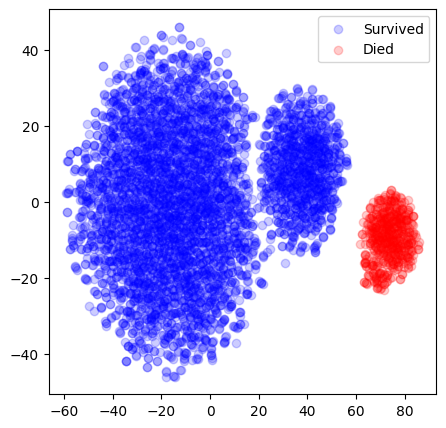

In [2]:
from sklearn.preprocessing import StandardScaler
tsne = TSNE(n_components=2, random_state=0)
X = df_sample.drop(columns="mortality")
X = StandardScaler().fit_transform(X)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(5, 5))
plt.scatter(
    X_embedded[df_sample["mortality"] == 0, 0], 
    X_embedded[df_sample["mortality"] == 0, 1], 
    color="blue", 
    label="Survived",
    alpha=0.2,
)
plt.scatter(
    X_embedded[df_sample["mortality"] == 1, 0], 
    X_embedded[df_sample["mortality"] == 1, 1], 
    color="red", 
    label="Died",
    alpha=0.2,
)
plt.legend()
plt.show()

### Train GroupFasterRisk with Group Sparsity Constraints

In [3]:
from fasterrisk.wrapper import FasterRisk
from fasterrisk.binarization_util import BinBinarizer
from sklearn.model_selection import train_test_split

X, y = df_sample.drop('mortality', axis=1), df_sample['mortality']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.head()

,mbp_min,mbp_max,age,urine_output,ph_min,ph_max,pco2_min,pco2_max,po2_min,po2_max,heartrate_min,heartrate_max,resprate_min,resprate_max,gcs_min,gcs_max,mechvent
2135,67.547025,115.229068,71.909501,977.386147,7.025542,7.379500,36.035589,52.299745,52.223609,101.828952,63.626346,98.939689,14.191593,19.195373,6.0,14.0,0
4125,107.941496,137.957170,0.000000,0.000000,7.223756,7.398097,41.211523,47.164539,62.197140,104.036750,75.282804,100.597880,15.121155,17.264196,11.0,15.0,1
2354,74.597672,171.259725,19.268117,870.669041,7.373849,7.481696,31.080145,49.027016,55.966196,83.715336,61.905630,83.780216,10.763224,19.453636,8.0,12.0,1
155,171.202324,184.983593,63.330171,831.289806,7.264517,7.030505,42.086837,38.170395,89.598352,93.273716,54.526179,92.946505,10.653171,16.755088,8.0,10.0,0
4873,66.277653,74.587320,94.071833,239.197167,7.275642,7.061231,27.580970,59.723110,67.411674,97.992201,56.333157,108.781607,9.828735,19.576288,7.0,15.0,0


Apply binarization, `max_num_thresholds_per_feature` can be any (as long as it divides 100), `max_num_thresholds_per_feature` controls the width of the binarization intervals. For instance, if `max_num_thresholds_per_feature=10`, then each interval will be between nth and (n+10)th percentile

If `group_sparsity=True`, returns group indices for every feature as well, else `None`

In [4]:
binarizer = BinBinarizer(max_num_thresholds_per_feature=10, whether_interval=False, group_sparsity=True)
X_train_binarized, group_idx = binarizer.fit_transform(X_train)     # binarize features based on training data
print(f"Number of binarized features: {len(X_train_binarized.columns)}")
list(X_train_binarized.columns[:27])            # 3*9=27 for the first three features

Number of binarized features: 162


['mbp_min<=79.58360205198792',
 'mbp_min<=86.15969780779426',
 'mbp_min<=91.47203697495456',
 'mbp_min<=102.29378361319388',
 'mbp_min<=116.10856618793571',
 'mbp_min<=118.85023577262267',
 'mbp_min<=128.3382531420785',
 'mbp_min<=132.8327508723682',
 'mbp_min<=159.96779440061323',
 'mbp_min<=187.5353513198002',
 'mbp_max<=71.22975257951565',
 'mbp_max<=124.35177097841765',
 'mbp_max<=128.8651400227865',
 'mbp_max<=154.38601218824647',
 'mbp_max<=157.42009528755486',
 'mbp_max<=159.5867464223987',
 'mbp_max<=162.83083014591665',
 'mbp_max<=185.18685735156615',
 'mbp_max<=188.40273979761903',
 'mbp_max<=189.70245573738563',
 'age<=33.51932478141815',
 'age<=37.05872798931772',
 'age<=42.503759561525634',
 'age<=43.413065024184725',
 'age<=54.66693302517876',
 'age<=55.09296084805071',
 'age<=57.32363590282395']

In [5]:
group_idx

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16])

Train GroupFasterRisk

In [6]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
fasterrisk = FasterRisk(
    k=25,       # the total number of binarized features to select
    lb=-90,     # lower bound of the coefficients
    ub=90,      # upper bound of the coefficients
    group_sparsity=4,  # the total number of groups (in our case, features) to select
    featureIndex_to_groupIndex=group_idx,   # the mapping from feature index to group index
    gap_tolerance=50,   # tolerance for the logistic loss between alternative models
)
fasterrisk.fit(X_train_binarized, y_train.replace({0:-1}))      # replace 0 to -1 for binary classification

X_test_binarized, _ = binarizer.transform(X_test)       # binarize test data based on thresholds obtained from training data
y_prob = fasterrisk.predict_proba(X_test_binarized)       # predict probability of death for test data
auroc = roc_auc_score(y_test, y_prob)       # compute AUC
pre, rec, _ = precision_recall_curve(y_test, y_prob)   # compute precision-recall curve
auprc = auc(rec, pre)     # compute AUC of precision-recall curve
print(f"AUROC: {auroc:.3f}, AUPRC: {auprc:.3f}")

AUROC: 1.000, AUPRC: 1.000


Visualize card (`model_idx` specifies which model you want to visualize, `0` being the top model with smallest logistic loss, `1` being the second top one with smallest loss..etc)

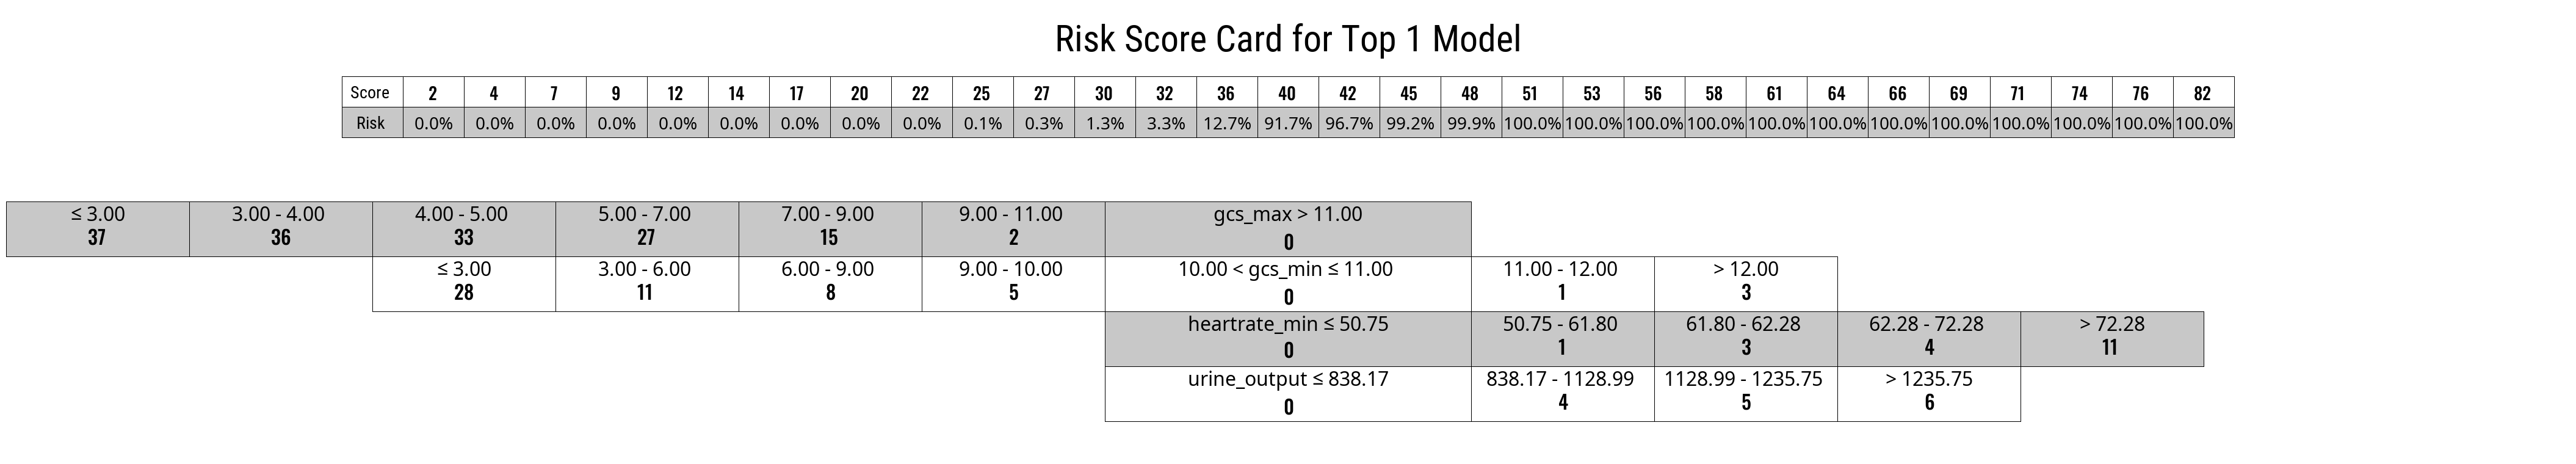

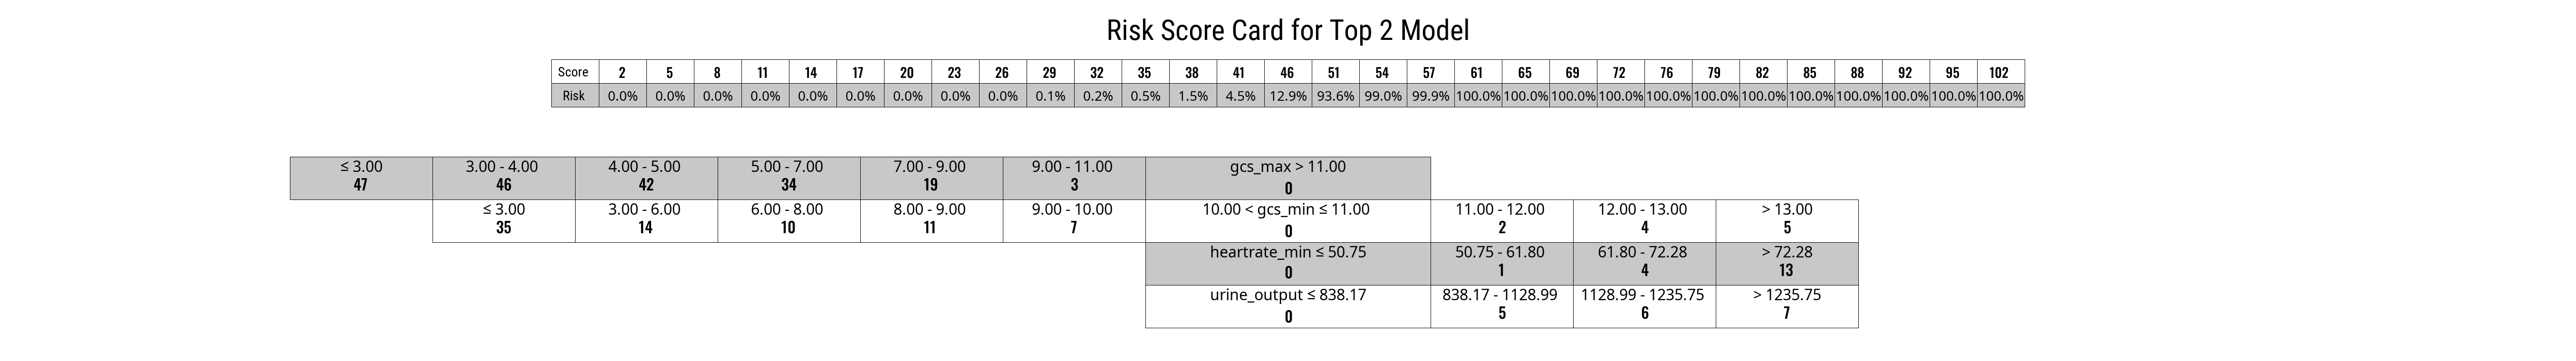

In [7]:
from IPython.display import display
from fasterrisk.binarization_util import BinBinarizer
names = list(X_train_binarized.columns)
for i in range(2):
    card = fasterrisk.visualize_risk_card(names, X_train_binarized, model_idx=i, title=f'Risk Score Card for Top {i+1} Model')      
    display(card)

Obtain model parameters

In [8]:
multipliers, beta0, betas = fasterrisk.get_model_params()
print(f"Multipliers: {multipliers}")
print(f"Intercept: {beta0}")
print(f"Coefficients: {betas}")

Multipliers: [2.07672079 2.61517234 2.61501319 4.23148299 3.15323781 4.23104228
 2.07706743 2.07634628]
Intercept: [ -8. -10. -10. -16. -13. -16.  -8.  -8.]
Coefficients: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Monotonicity Constraint
Monotonicity constraint can be particularly useful when one wants to include domain knowledge in the risk score output. This could matter in empirical scenarios where the bias in the training dataset contributes to unrealistic findings that may not generalize well. To demonstrate how this is useful, we would like to use the example below.

### Example
Suppose there is a consistent data collection error for patients with Glascow Coma Score of 3, causing all patients with `gcs = 3` to be labelled as negatives (alive). 

In [9]:
y_train_w = y_train.copy()
y_train_w[ (X["gcs_min"] == 3) | (X["gcs_max"] == 3) ] = 0

The GroupFasterRisk risk scores reflect this underlying consistent error, thanks to its interpretable risk score card:

AUROC: 0.696, AUPRC: 0.455


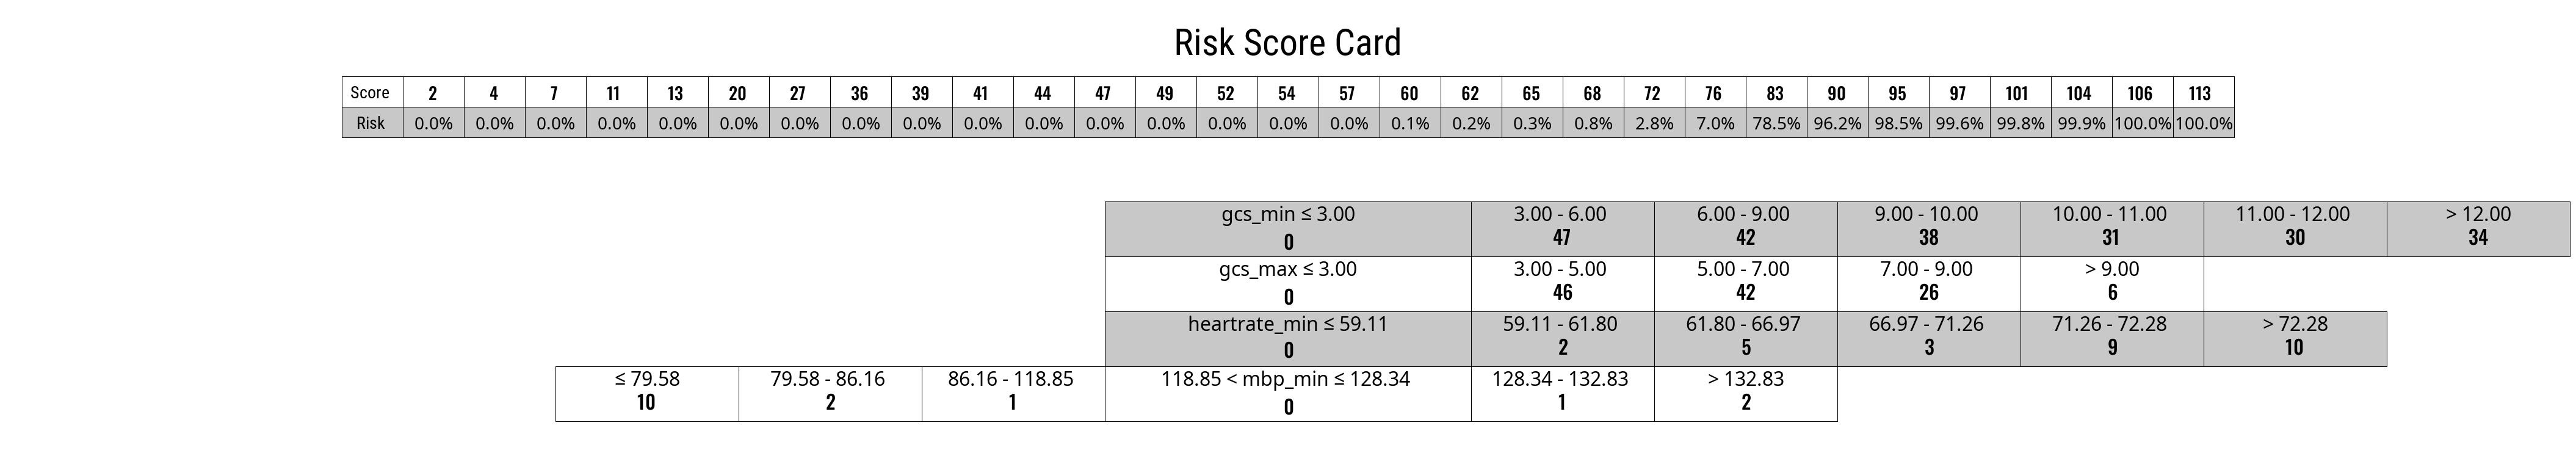

In [10]:
fasterrisk = FasterRisk(
    k=25,       # the total number of binarized features to select
    lb=-90,     # lower bound of the coefficients
    ub=90,      # upper bound of the coefficients
    group_sparsity=4,  # the total number of groups (in our case, features) to select
    featureIndex_to_groupIndex=group_idx,   # the mapping from feature index to group index
    gap_tolerance=50,   # tolerance for the logistic loss between alternative models
)
fasterrisk.fit(X_train_binarized, y_train_w.replace({0:-1}))      # replace 0 to -1 for binary classification

X_test_binarized, _ = binarizer.transform(X_test)       # binarize test data based on thresholds obtained from training data
y_prob = fasterrisk.predict_proba(X_test_binarized)       # predict probability of death for test data
auroc = roc_auc_score(y_test, y_prob)       # compute AUC
pre, rec, _ = precision_recall_curve(y_test, y_prob)   # compute precision-recall curve
auprc = auc(rec, pre)     # compute AUC of precision-recall curve
print(f"AUROC: {auroc:.3f}, AUPRC: {auprc:.3f}")

card = fasterrisk.visualize_risk_card(names, X_train_binarized, model_idx=0, title=f'Risk Score Card')      
display(card)

Observe that the component function for `gcs_max` generally has a negative correlation with risk (lower `gcs`, higher risk), except for `gcs_max <= 3`. We also have a similar observation for `gcs_min`. After consulting with relevant experts, we found that this is generally contradictory to the domain knowledge that `gcs <= 3` highly correlates with high mortality risk. To include such domain knowledge, we can apply monotonicity constraints on `gcs_min` and `gcs_max`

In [11]:
[e for e in X_train_binarized.columns if "gcs" in e]

['gcs_min<=3.0',
 'gcs_min<=6.0',
 'gcs_min<=8.0',
 'gcs_min<=9.0',
 'gcs_min<=10.0',
 'gcs_min<=11.0',
 'gcs_min<=12.0',
 'gcs_min<=13.0',
 'gcs_min<=14.0',
 'gcs_min<=15.0',
 'gcs_max<=3.0',
 'gcs_max<=4.0',
 'gcs_max<=5.0',
 'gcs_max<=7.0',
 'gcs_max<=9.0',
 'gcs_max<=10.0',
 'gcs_max<=11.0',
 'gcs_max<=13.0',
 'gcs_max<=14.0',
 'gcs_max<=15.0']

Apply monotonicity constraint

In [12]:
# first entry is lower bound, second entry is upper bound, so setting to (0, 90) 
# forces coefficient to be positive, which enforces monotonically decreasing relationship 
# between GCS and mortality risk
user_defined_pairs = {e: (0, 90) for e in X_train_binarized.columns if "gcs" in e}
lb_list, ub_list = fasterrisk.define_bounds(X_train_binarized, feature_bound_pairs=user_defined_pairs, lb_else=-90, ub_else=90)

AUROC: 0.999, AUPRC: 0.984


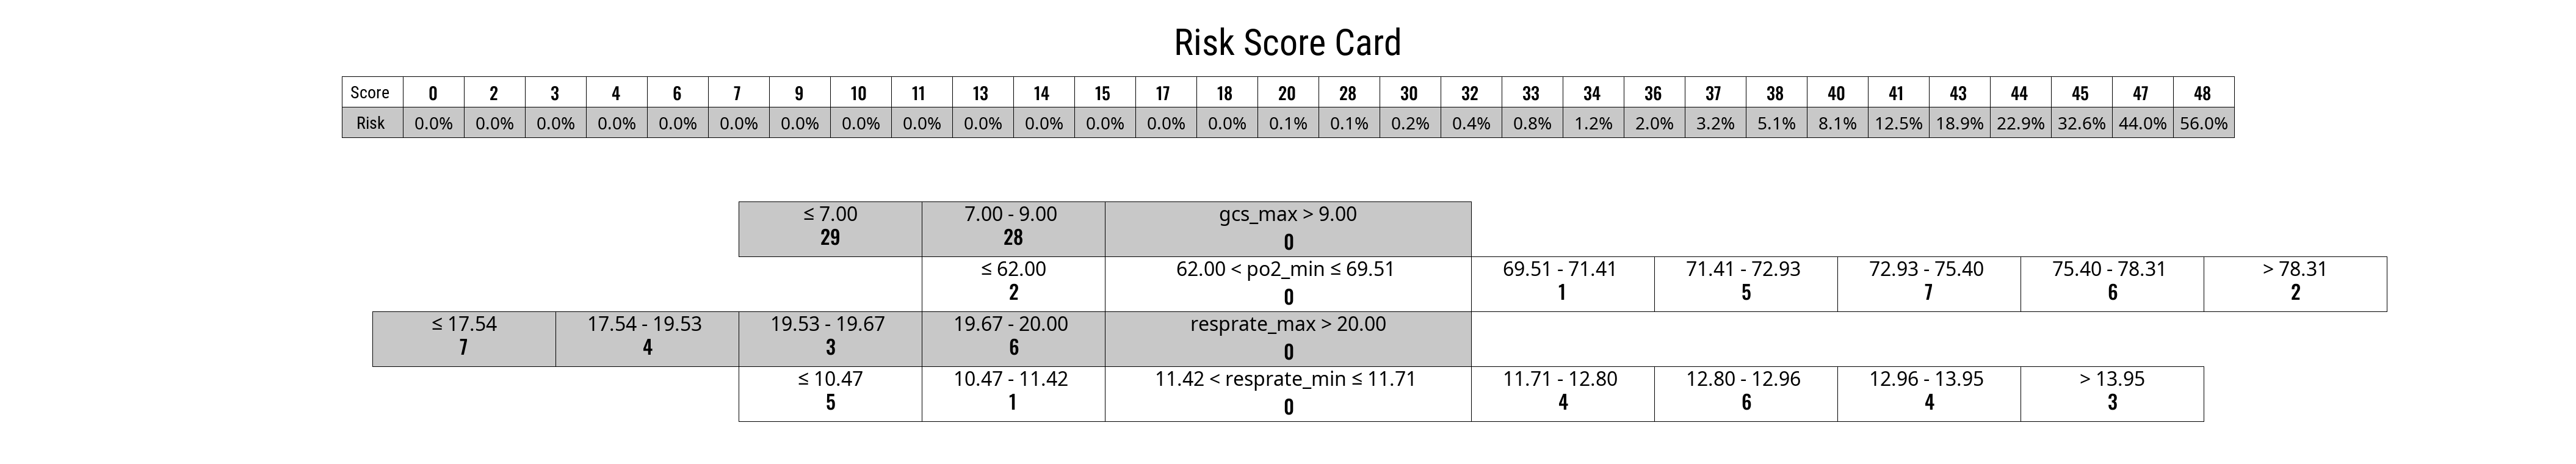

In [13]:
fasterrisk = FasterRisk(
    k=25,       # the total number of binarized features to select
    lb=lb_list,     # use lower bounds derived from domain knowledge
    ub=ub_list,      # use upper bounds derived from domain knowledge
    group_sparsity=4,  # the total number of groups (in our case, features) to select
    featureIndex_to_groupIndex=group_idx,   # the mapping from feature index to group index
    gap_tolerance=50,   # tolerance for the logistic loss between alternative models
)
fasterrisk.fit(X_train_binarized, y_train_w.replace({0:-1}))      # replace 0 to -1 for binary classification

X_test_binarized, _ = binarizer.transform(X_test)       # binarize test data based on thresholds obtained from training data
y_prob = fasterrisk.predict_proba(X_test_binarized)       # predict probability of death for test data
auroc = roc_auc_score(y_test, y_prob)       # compute AUC
pre, rec, _ = precision_recall_curve(y_test, y_prob)   # compute precision-recall curve
auprc = auc(rec, pre)     # compute AUC of precision-recall curve
print(f"AUROC: {auroc:.3f}, AUPRC: {auprc:.3f}")

card = fasterrisk.visualize_risk_card(names, X_train_binarized, model_idx=0, title=f'Risk Score Card')      
display(card)

The corrected risk score more accurately reflects the domain knowledge and performs better! Although this is just a naive toy example, it demonstrates the core idea behind GroupFasterRisk's new functionalities.